In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
import os
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error

In [4]:
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

In [5]:
data_folder = os.path.join(os.getcwd(), 'Datasets')
os.chdir(data_folder)

In [6]:
# Import and format dataframe
covid19_df = pd.read_csv('COVID-19-geographic-disbtribution-worldwide-2020-05-08.csv', engine='python')

In [7]:
covid19_df.head(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
0,08/05/2020,8,5,2020,171,2,Afghanistan,AF,AFG,37172386.0,Asia
1,07/05/2020,7,5,2020,168,9,Afghanistan,AF,AFG,37172386.0,Asia
2,06/05/2020,6,5,2020,330,5,Afghanistan,AF,AFG,37172386.0,Asia
3,05/05/2020,5,5,2020,190,5,Afghanistan,AF,AFG,37172386.0,Asia
4,04/05/2020,4,5,2020,235,13,Afghanistan,AF,AFG,37172386.0,Asia


In [8]:
# Columns to drop
drop_columns = ['geoId', 'day', 'month', 'year', 'countryterritoryCode', 'continentExp']
# Create a 'datetime' column based on the dates
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
# Drop the columns that add no value
covid19_df.drop(columns=drop_columns, inplace=True)
# Display the new table

In [9]:
# Optional to slice the data at a date in the past, I started doing this instead of using older datasets because for example the UK went and added deaths to dates in the past.
###covid19_df = covid19_df.loc[covid19_df['dateRep'] < '2020-03-17']

In [10]:
covid19_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
covid19_df['Cum Cases'] = covid19_df.groupby("countriesAndTerritories")['cases'].cumsum()
covid19_df['Cum Deaths'] = covid19_df.groupby("countriesAndTerritories")['deaths'].cumsum()
# Create column for days since x deaths
covid19_df['flag'] = np.where(covid19_df['Cum Cases'] > 100, 1, 0) # calculate globaly as its a true false
# groupby again creating a unique dataframe for each country, and applying a cumulative sum to the "flag" column
covid19_df['flag'] = covid19_df.loc[covid19_df['Cum Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

In [11]:
# Create new df
country_df = covid19_df.copy() 

In [12]:
# Create column for days since x deaths
country_df['flag'] = np.where(country_df['Cum Cases'] > 100, 1, 0) # calculate globaly as its a true false, no agregaton at this stage
# groupby again creating a unique dataframe for each country, and applying a cumulative sum to the "flag" column
country_df['flag'] = country_df.loc[country_df['Cum Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

In [13]:
# The daily pct change in cases and deaths for each country individually, a value of 1 = the same number of cases as the day before
country_df['case_rate_inc'] = 1 + country_df.groupby("countriesAndTerritories")['cases'].pct_change()
country_df['death_rate_inc'] = 1 + country_df.groupby("countriesAndTerritories")['deaths'].pct_change()

In [14]:
# Rolling avereage of the case and deaths rates over a 5 day window using the median, mean also useful
country_df['5D_MA_cases'] = country_df.groupby("countriesAndTerritories")['case_rate_inc'].rolling(window=5).median().reset_index(0,drop=True)
country_df['5D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['death_rate_inc'].rolling(window=5).median().reset_index(0,drop=True)

In [15]:
# Rolling avereage of the case and deaths rates over a 5 day window using the median, mean also useful
country_df['7D_MA_cases'] = country_df.groupby("countriesAndTerritories")['case_rate_inc'].rolling(window=7).median().reset_index(0,drop=True)
country_df['7D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['death_rate_inc'].rolling(window=7).median().reset_index(0,drop=True)

In [16]:
# Slice the dataframe at a previous point in time, so for example slice from mid march and see what the prediction would be for the present day
country_df = country_df.loc[country_df['dateRep'] < '2020-04-24']

In [17]:
# Find the countries with the most deaths, top 20 usually used but can vary it
top_count = country_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]

In [18]:
top_count = pd.DataFrame(top_count)
top_count

,deaths
countriesAndTerritories,
United_States_of_America,46784
Italy,25085
Spain,22157
France,21340
United_Kingdom,21060
Belgium,6262
Iran,5391
Germany,5094
China,4636


In [19]:
# Creates a list of the countries only from the dataframe we created.
top_count = list(top_count.index)

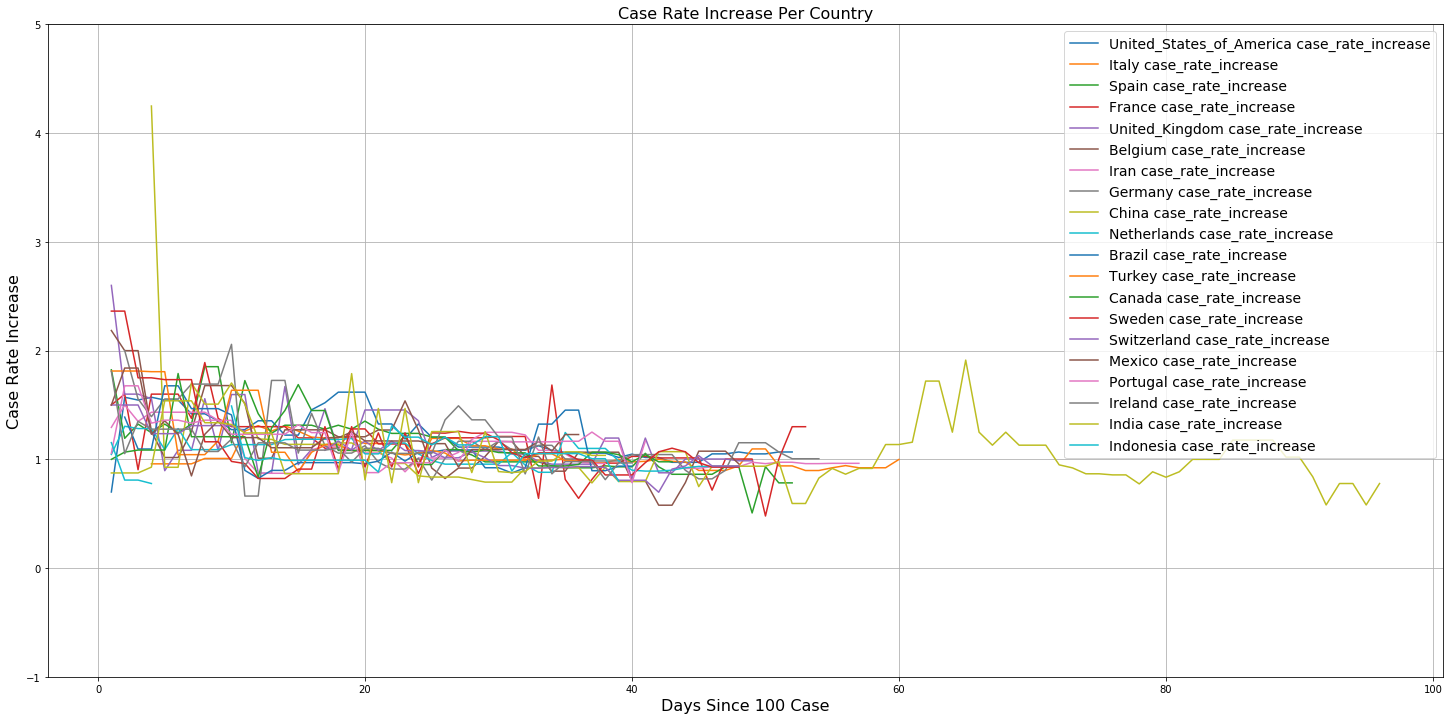

In [20]:
# Visualising the Linear Regression results
# Display the rate of change in cases where 1 = no change in cases from the day before.
# Looks messy but general downward trend observed from 0 to 40 days.
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df[country_df["countriesAndTerritories"] == country]["flag"],
             country_df[country_df["countriesAndTerritories"] == country]["5D_MA_cases"], label=f"{country} case_rate_increase")
plt.title('Case Rate Increase Per Country')
plt.xlabel('Days Since 100 Case')
plt.ylabel('Case Rate Increase')
plt.ylim(-1, 5)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

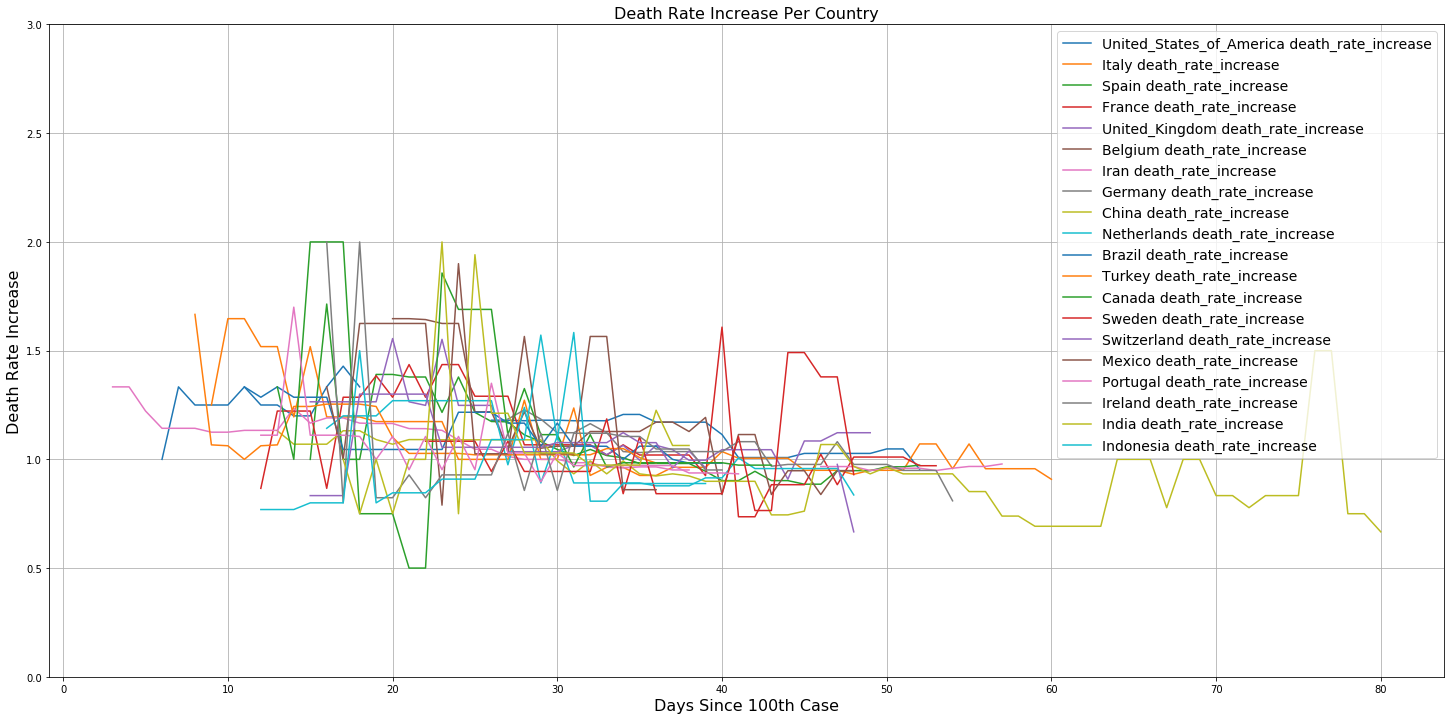

In [21]:
# Visualising the Linear Regression results.
# Same again but for the deaths instead.
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df[country_df["countriesAndTerritories"] == country]["flag"],
             country_df[country_df["countriesAndTerritories"] == country]["7D_MA_deaths"], label=f"{country} death_rate_increase")
plt.title('Death Rate Increase Per Country')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Death Rate Increase')
plt.ylim(0, 3)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

In [22]:
# Here we select only the countries in the 'top_count' list and groupby 'days since 100 case' and take the mean.
# This gives us a global average per day, adjusted so that the 100th case per country is day 1.
country_df_mean = country_df[country_df['countriesAndTerritories'].isin(top_count)].groupby('flag').mean()

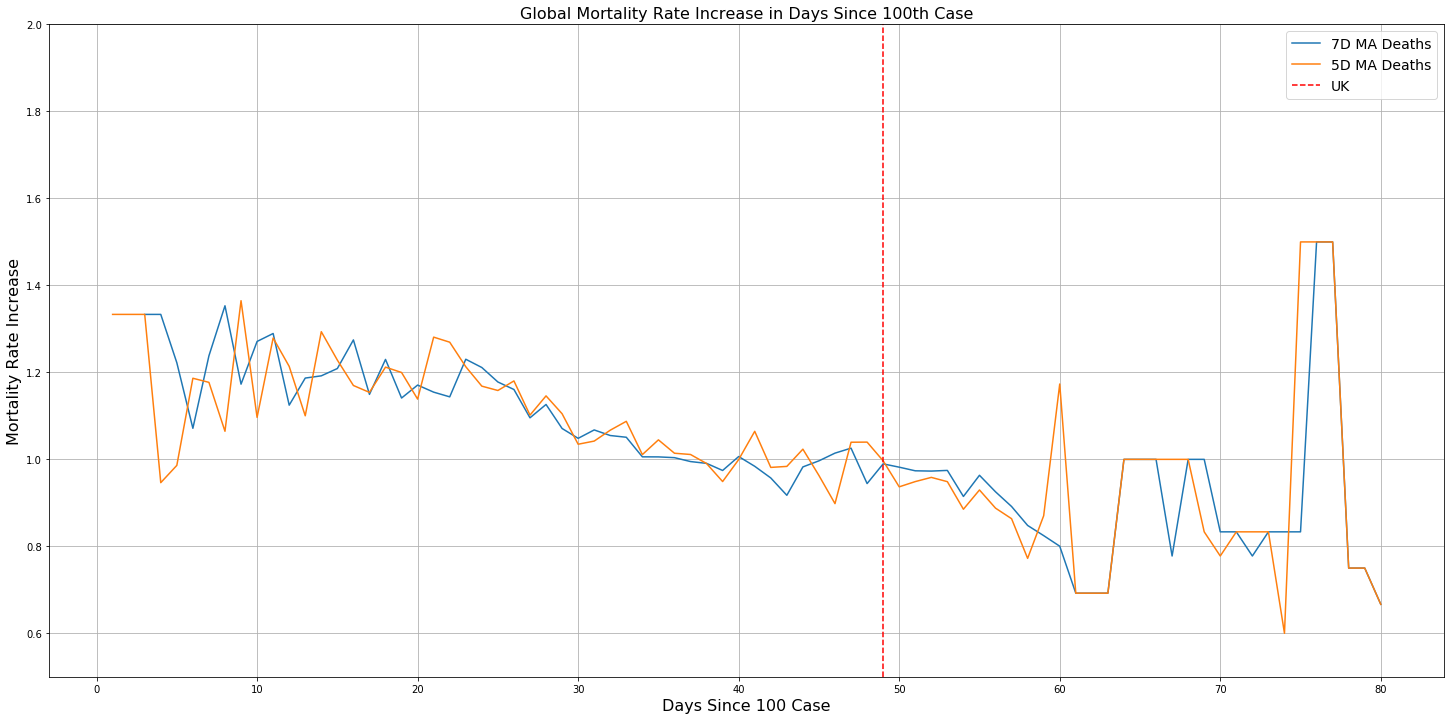

In [23]:
# Plot the global average death rate per day.
# This plot now makes more sense and we can see the general change in growth rate that would be expected.
uk_max = country_df[country_df['countriesAndTerritories'] =="United_Kingdom"]['flag'].max()
plt.figure(figsize=(25, 12))
plt.plot(country_df_mean.index, country_df_mean['7D_MA_deaths'], label='7D MA Deaths')
plt.plot(country_df_mean.index, country_df_mean['5D_MA_deaths'], label='5D MA Deaths')
plt.axvline(x=uk_max, linestyle='--', color='red', label='UK')
#plt.plot(country_df_mean.index, country_df_mean['death_rate_inc'], label='Death Rate Inc')
plt.title('Global Mortality Rate Increase in Days Since 100th Case')
plt.xlabel('Days Since 100 Case')
plt.ylabel('Mortality Rate Increase')
plt.ylim(0.5, 2)
plt.grid()
plt.legend()
#plt.savefig('Global_Average_DRate_dpi300.jpeg', dpi=300)

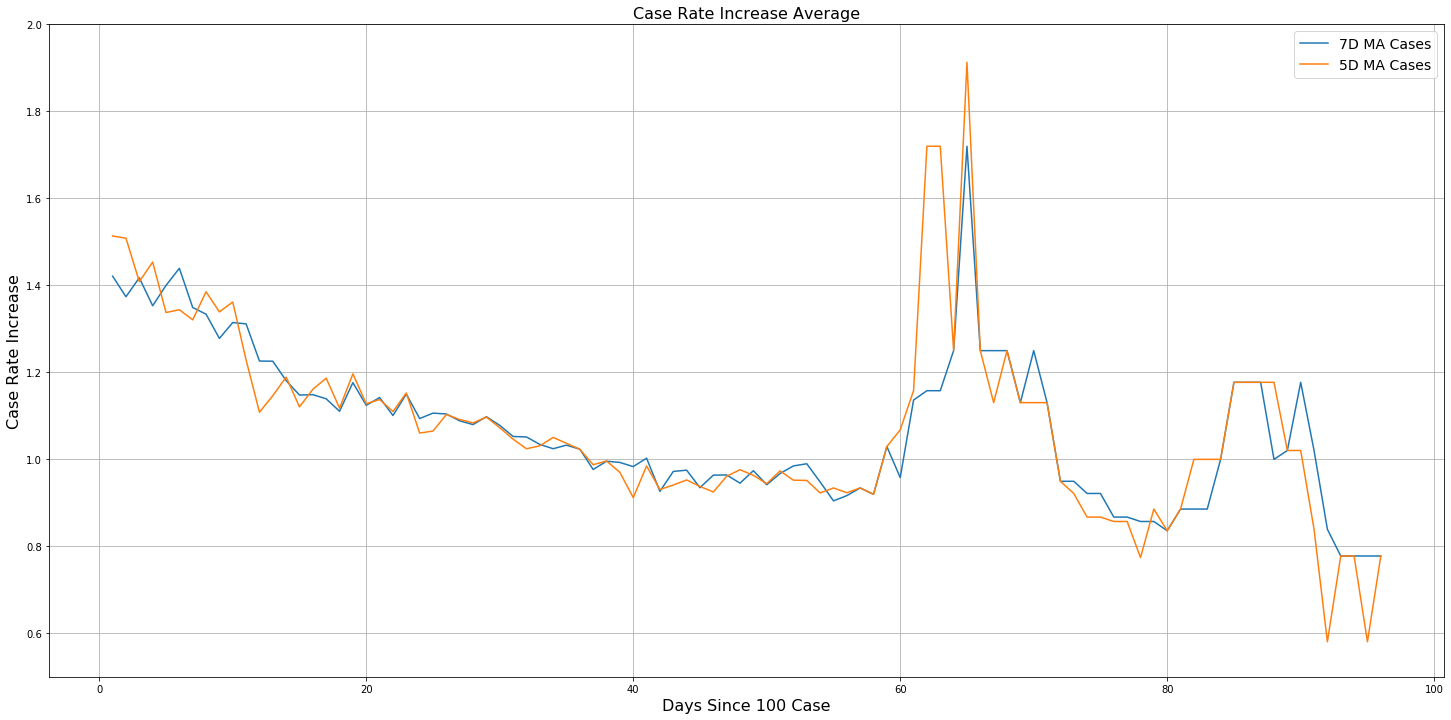

In [24]:
# Plot the global average case rate per day past 100th case.
# More clarity here again for the change in the growth of cases. (1 = no change on the previous day)
plt.figure(figsize=(25, 12))
plt.plot(country_df_mean.index, country_df_mean['7D_MA_cases'], label='7D MA Cases')
plt.plot(country_df_mean.index, country_df_mean['5D_MA_cases'], label='5D MA Cases')
#plt.plot(country_df_mean.index, country_df_mean['case_rate_inc'], label='Case Rate Increase (Daily)')
plt.title('Case Rate Increase Average')
plt.xlabel('Days Since 100 Case')
#plt.legend()
plt.ylabel('Case Rate Increase')
plt.ylim(0.5, 2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
plt.show()

In [25]:
# Fill the null values for the 'flag' and 'case_rate_inc' columns
country_df.flag.fillna(0, inplace=True) # fill the nans in the flag column as a reult of merging in the filtered groupby
country_df.case_rate_inc.fillna(0, inplace=True) # fill the nans in the case rate column as a reult of mergining in the filtered groupby

In [26]:
# Drop columns not needed in global average table
country_df_mean.drop(['cases', 'deaths', 'Cum Cases', 'Cum Deaths', 'popData2018'], axis=1, inplace=True)

In [27]:
# Slice the data from the first day of 'flag', previous days - i.e. before the 100th case are not needed here.
# This ensures the df matches the index of the 'country_df_2' df, rename columns suffix 'global'.
country_df_mean = country_df_mean.loc[(country_df_mean.index > 0)]
country_df_mean.rename(columns={"case_rate_inc": "case_rate_inc_global", "death_rate_inc": "death_rate_inc_global",\
                                '5D_MA_cases':'5D_MA_cases_global', '5D_MA_deaths': '5D_MA_deaths_global', '7D_MA_cases': '7D_MA_cases_global', '7D_MA_deaths':'7D_MA_deaths_global'}, inplace=True)
country_df_mean.head(3)

,case_rate_inc_global,death_rate_inc_global,5D_MA_cases_global,5D_MA_deaths_global,7D_MA_cases_global,7D_MA_deaths_global
flag,,,,,,
1.0,2.536642,inf,1.513647,1.333333,1.421273,NaN
2.0,1.413003,inf,1.508591,1.333333,1.374034,NaN
3.0,1.626906,inf,1.408719,1.333333,1.417492,1.333333


In [28]:
# Create a secondary country df that is prepped to be merged with the global mean one.
# Rolling 5 day averages for cases and deaths calculated so that they can be used to predict future deaths/ cases 
country_df_2 = country_df.drop(['5D_MA_cases', '5D_MA_deaths', '7D_MA_cases', '7D_MA_deaths', 'case_rate_inc', 'death_rate_inc'], axis=1)
country_df_2['5D_MA_cases'] = country_df.groupby("countriesAndTerritories")['cases'].rolling(window=5).mean().reset_index(0,drop=True)
country_df_2['5D_MA_deaths'] = country_df.groupby("countriesAndTerritories")['deaths'].rolling(window=5).mean().reset_index(0,drop=True)

In [29]:
# Find the country with the longest number of days since 100th case (China) and extrapolate each countries number of days to that amount with their own respective dates, etc added.
# 'cum_7D_MA_deaths_global' is an attribute calculating the cumlative relative deathrate since the last real value. So the number at the last real value is '1' and if the subsecquent number was 2, tha would mean the daily deaths that day were twice as much as the day before. Initially populated with 1's and subsequently calculated later on.
# '7D_DeathPred' initially populated with the daily death tally on the day with the last real data, this is then multiplied by the 'cum_7D_MA_deaths_globally' to find the prediced daily deaths for any day in the future.

for country in top_count:
    country_len = len(country_df_2.loc[(country_df_2['countriesAndTerritories'] == country) & (country_df_2['flag'] > 0)])
    blank_df = pd.DataFrame(columns=['flag', 'countriesAndTerritories', 'dateRep', 'popData2018', 'continentExp', 'cum_7D_MA_deaths_global', '7D_DeathPred'], index=np.arange(len(country_df_mean) - country_len))
    for i in range(len(country_df_mean) - country_len):
        date_value_max = pd.DateOffset(i + 1) + country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max()
        pop_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['popData2018'].iloc[0]
        #continentExp_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['continentExp'].iloc[0]
        deathpred_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['5D_MA_deaths'].iloc[0]
        #deathpred_value = country_df_2.loc[(country_df_2['dateRep'] == (country_df_2.loc[(country_df_2['countriesAndTerritories'] == country)]['dateRep'].max())) & (country_df_2['countriesAndTerritories'] == country)]['deaths'].iloc[0]
        cumprod_value = 1
        blank_df = blank_df.append({'flag': (i + country_len + 1), 'countriesAndTerritories': country, 'dateRep': date_value_max, 'popData2018': pop_value, 'cum_7D_MA_deaths_global': 1, '7D_DeathPred': deathpred_value}, ignore_index=True) # 'continentExp': continentExp_value,
    country_df_2 = pd.concat([country_df_2, blank_df])
country_df_2.loc[country_df_2['countriesAndTerritories'] == 'United_Kingdom'].tail()

,dateRep,cases,deaths,countriesAndTerritories,popData2018,Cum Cases,Cum Deaths,flag,5D_MA_cases,5D_MA_deaths,continentExp,cum_7D_MA_deaths_global,7D_DeathPred
89,2020-06-05,NaN,NaN,United_Kingdom,66488991.0,NaN,NaN,92,NaN,NaN,NaN,1,836.2
90,2020-06-06,NaN,NaN,United_Kingdom,66488991.0,NaN,NaN,93,NaN,NaN,NaN,1,836.2
91,2020-06-07,NaN,NaN,United_Kingdom,66488991.0,NaN,NaN,94,NaN,NaN,NaN,1,836.2
92,2020-06-08,NaN,NaN,United_Kingdom,66488991.0,NaN,NaN,95,NaN,NaN,NaN,1,836.2
93,2020-06-09,NaN,NaN,United_Kingdom,66488991.0,NaN,NaN,96,NaN,NaN,NaN,1,836.2


In [30]:
# Merge global average attributes into country_df_2, so on 'days past 100 case' there is an global mean change in deaths/ cases at 1, 5 and 7 day increments.

country_df_2 = country_df_2.merge(country_df_mean, left_on=country_df_2.flag, right_on=country_df_mean.index)

In [31]:
# First stage of 'cum_7D_MA_deaths_global' is to populate the column with the global running average value.

country_df_2['cum_7D_MA_deaths_global'] = country_df_2['cum_7D_MA_deaths_global'] * country_df_2['7D_MA_deaths_global']

In [32]:
# Second stage of 'cum_7D_MA_deaths_global' is to convert to float, then run .cumprod, to calculate the cumulative product relative to the last real value.
# '7D_DeathPred' is then calculated by multiplying the last real value of daily deaths with the 'cum_7D_MA_deaths_global' to find the predicted value based on the 7D moving average changing in death rate.

country_df_2['cum_7D_MA_deaths_global'] = country_df_2['cum_7D_MA_deaths_global'].astype(float)
country_df_2['cum_7D_MA_deaths_global'] = country_df_2.groupby('countriesAndTerritories')['cum_7D_MA_deaths_global'].cumprod()
country_df_2['7D_DeathPred'] = country_df_2['7D_DeathPred'] * country_df_2['cum_7D_MA_deaths_global']

In [33]:
# '7D_Full_Death' is created initially using the daily predicted deaths, then the .fillna fills in the previous values with the real daily deaths from the original 'deaths' column

country_df_2['7D_Full_Death'] = country_df_2['7D_DeathPred']
country_df_2['7D_Full_Death'].fillna(country_df_2.deaths, inplace=True)

In [34]:
# '7D_Full_Death_cum' calculates the cumulative total of the original real values with the future predicted values.

country_df_2['7D_Full_Death_cum'] = country_df_2.groupby('countriesAndTerritories')['7D_Full_Death'].cumsum()

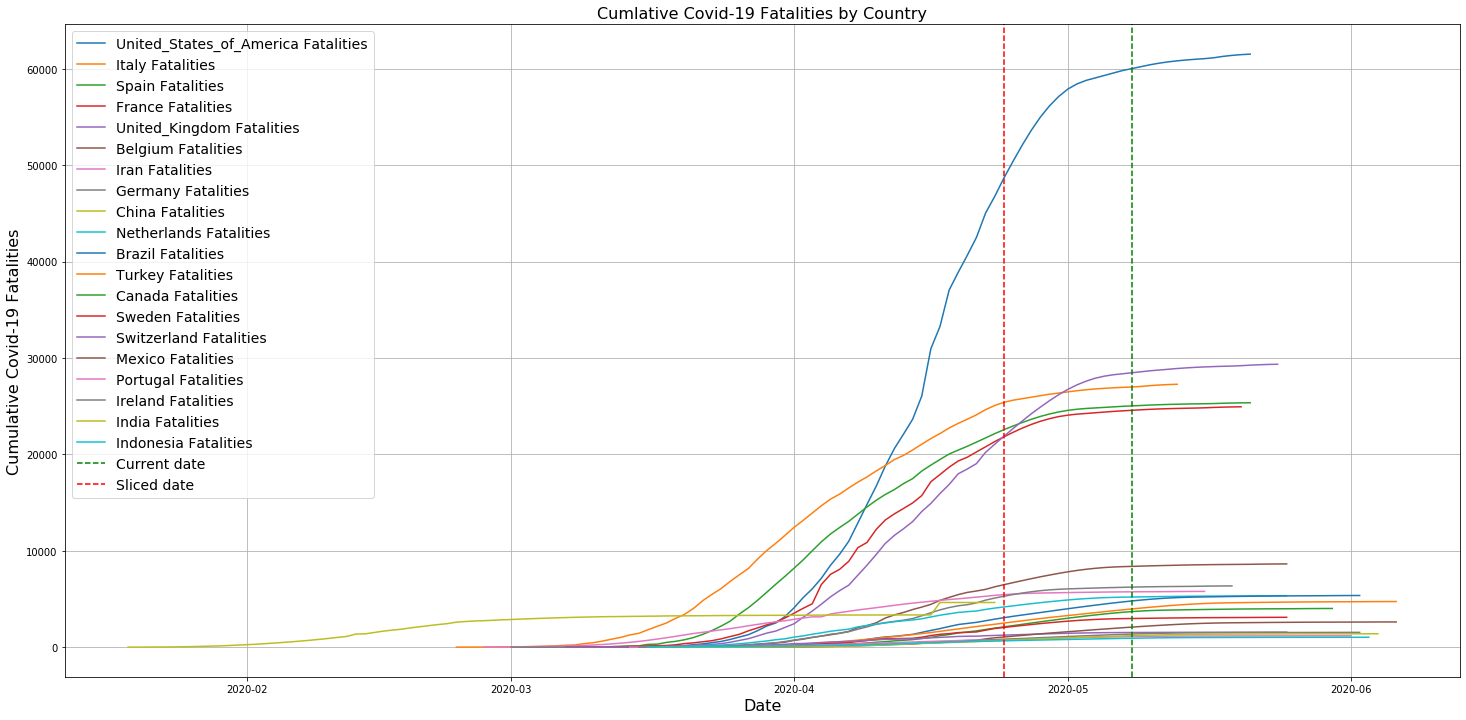

In [35]:
# Visualising the Linear Regression results for each country, cumulative totals with real and future predicted values up to the maxmum 'days since 100 case' which is China
cur_date = '2020-05-08'
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df_2[country_df_2["countriesAndTerritories"] == country]["dateRep"],
             country_df_2[country_df_2["countriesAndTerritories"] == country]["7D_Full_Death_cum"], label=f"{country} Fatalities")
plt.axvline(dt.datetime(2020, 5, 8), linestyle='--', color='green', label='Current date')
plt.axvline(dt.datetime(2020, 4, 24), linestyle='--', color='red', label='Sliced date')
plt.title('Cumlative Covid-19 Fatalities by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Covid-19 Fatalities')
plt.ylim()
#plt.yscale('log', basey=2)
#plt.xlim(0, 90)
plt.grid()
plt.legend()
#plt.savefig('cumulative_fatalities_20_countries_manual_dpi300.jpeg', dpi=300)

In [36]:
# Merge in the original dataframe so that real deaths can be compared against the predicted deaths (This is only useful if the dataframe was sliced at a previous date in time)
country_df_compare = country_df_2[['dateRep', '7D_Full_Death_cum', 'countriesAndTerritories']].merge(covid19_df[['Cum Deaths', 'dateRep', 'countriesAndTerritories']], on=['dateRep', 'countriesAndTerritories'])

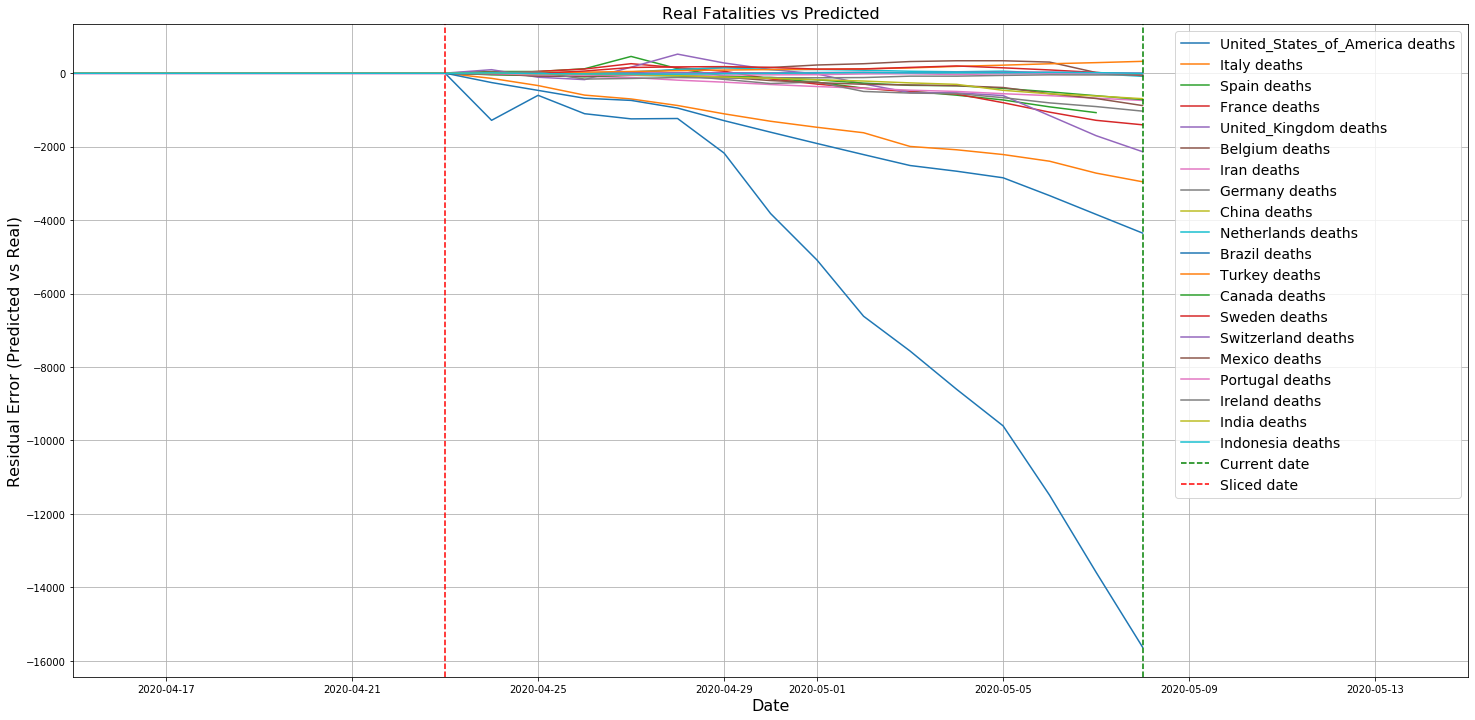

In [37]:
# The difference in predicted vs real deaths for each country
plt.figure(figsize=(25, 12))
for country in top_count:
    plt.plot(country_df_compare[country_df_compare["countriesAndTerritories"] == country]["dateRep"],
             (country_df_compare[country_df_compare["countriesAndTerritories"] == country]["7D_Full_Death_cum"] - country_df_compare[country_df_compare['countriesAndTerritories'] == country]['Cum Deaths']), label=f"{country} deaths")

plt.axvline(dt.datetime(2020, 5, 8), linestyle='--', color='green', label='Current date')
plt.axvline(dt.datetime(2020, 4, 23), linestyle='--', color='red', label='Sliced date')
plt.title('Real Fatalities vs Predicted')
plt.xlabel('Date')
plt.ylabel('Residual Error (Predicted vs Real)')
plt.ylim()
#plt.yscale('log', basey=2)
plt.xlim(dt.datetime(2020, 4, 15), dt.datetime(2020, 5, 15))
plt.grid()
plt.legend()
#plt.savefig('cumulative_error_20_countries_manual_dpi300.jpeg', dpi=300)

In [38]:
# Create yet another df that contains real and predicted deaths only past the date we sliced on.
country_df_3 = covid19_df.merge(country_df_2, left_on=['dateRep', 'countriesAndTerritories'], right_on=['dateRep', 'countriesAndTerritories'])
country_df_3 = country_df_3[['deaths_x', '7D_DeathPred', 'dateRep', 'flag_x', 'countriesAndTerritories']]
country_df_3 = country_df_3.loc[(country_df_3['dateRep'] > '2020-04-23')]
country_df_3 = country_df_3[country_df_3['countriesAndTerritories'].isin(top_count)]

In [39]:
# Calculate metrics to measure the accuracy of the prediction.
print(f"DL MAE score: {np.round(mean_absolute_error(country_df_3.deaths_x, country_df_3['7D_DeathPred']))}")
print(f"DL R2 score: {np.round(r2_score(country_df_3.deaths_x, country_df_3['7D_DeathPred']), 4)}")

DL MAE score: 139.0
DL R2 score: 0.4794


In [43]:
# Create a df and populate with the metrics from the three different models.
d = {'Method': ['XGBoost', 'Manual', 'NN'], 'MAE': [ 120.0, 139.0, 168.0], 'R2': [ 0.7372, 0.4794, 0.635]}
test_results = pd.DataFrame(data=d)
test_results.head(5)

,Method,MAE,R2
0,XGBoost,120.0,0.7372
1,Manual,139.0,0.4794
2,NN,123.0,0.7990


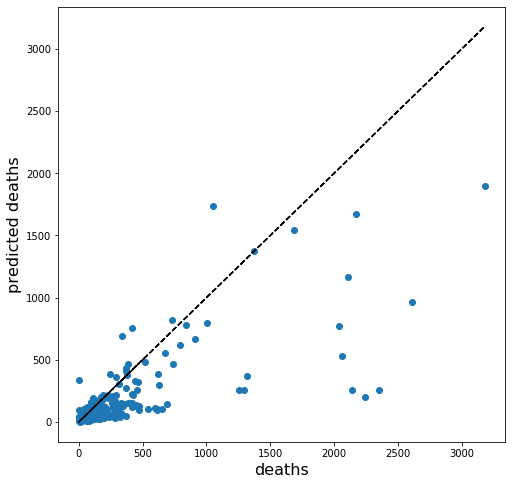

In [41]:
# A simple scatter plot showing real vs predicted data.
# The dashed line equals a 1 to 1 ratio- perfect prediction.
plt.figure(figsize=(8, 8))
plt.scatter(country_df_3.deaths_x, country_df_3['7D_DeathPred'])
plt.plot(country_df_3.deaths_x, country_df_3.deaths_x, color="black", linestyle="--")
plt.xlabel("deaths")
plt.ylabel("predicted deaths")
plt.show()

In [42]:
#country_df_compare['residual_2020_04_20'] = country_df_compare["7D_Full_Death_cum"] - country_df_compare['Cum Deaths']